# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [86]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from newsapi.newsapi_client import NewsApiClient
from datetime import datetime, timedelta

import nltk as nltk

nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

%config Completer.use_jedi = False

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alba/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read your api key environment variable

load_dotenv()

# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["news_api_key"])

In [3]:
current_date = pd.Timestamp(
    datetime.now(), tz="America/Chicago"
).isoformat()

past_date = pd.Timestamp(
    datetime.now() - timedelta(10), tz="America/Chicago"
).isoformat()



#HELPER FUNCTION: Use newsapi client to get most relevant 20 articles per day
# in the past 10 days
def get_articles(keyword):

    all_headlines = []
    all_texts = []
    all_dates = []

    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")

    print(f"Fetching news about '{keyword}'")
    print("*" * 30)

    while date > end_date:

        print(f"retrieving news from: {date}")

        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page=1,
        )

        headlines = []
        texts = []

        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
            texts.append(articles["articles"][i]["content"])

        all_headlines.append(headlines)
        all_texts.append(texts)
        all_dates.append(date)

        date = date - timedelta(days=1)

    return all_headlines, all_texts, all_dates


In [4]:
#HELPER FUNCTION: Sentiment scores for text
def get_text_sentiment(text):
    try:
        text_sentiment = analyzer.polarity_scores(text)
    
        compound_sent = text_sentiment["compound"]
        pos_sent = text_sentiment["pos"]
        neu_sent = text_sentiment["neu"]
        neg_sent = text_sentiment["neg"]

        return [compound_sent, pos_sent, neu_sent, neg_sent]
    
    except AttributeError:
        return [np.nan, np.nan, np.nan, np.nan]

#HELPER FUNCTION: Sentiment scores for an article
def get_article_sentiment(headline, text): 

    headline_sent = get_text_sentiment(headline)
    text_sent = get_text_sentiment(text)
    total_sent = get_text_sentiment(headline + text)

    return [headline_sent, text_sent, total_sent]



#HELPER FUNCTION: Sentiment score for a given day
def get_daily_sentiment_avg(headlines, texts):
    
    assert len(headlines) == len(texts), f"Number of titles and texts should be the same"
    num_days = len(texts)
    
    headline_com_sents = []
    headline_pos_sents = []
    headline_neu_sents = []
    headline_neg_sents = []
    
    text_com_sents = []
    text_pos_sents = []
    text_neu_sents = []
    text_neg_sents = []
    
    total_com_sents = []
    total_pos_sents = []
    total_neu_sents = []
    total_neg_sents = []
    
    for (headline, text) in zip(headlines, texts):
        
        headline_sent, text_sent, total_sent = \
            get_article_sentiment(headline, text)
        
        headline_com_sents.append(headline_sent[0])
        headline_pos_sents.append(headline_sent[1])
        headline_neu_sents.append(headline_sent[2])
        headline_neg_sents.append(headline_sent[3])
    
        text_com_sents.append(text_sent[0])
        text_pos_sents.append(text_sent[1])
        text_neu_sents.append(text_sent[2])
        text_neg_sents.append(text_sent[3])
    
        total_com_sents.append(total_sent[0])
        total_pos_sents.append(total_sent[1])
        total_neu_sents.append(total_sent[2])
        total_neg_sents.append(total_sent[3])

        
    headline_avg = [np.nanmean(headline_com_sents),
                    np.nanmean(headline_pos_sents),
                    np.nanmean(headline_neu_sents),
                    np.nanmean(headline_neg_sents)]

    
    
    text_avg = [np.nanmean(text_com_sents),
                    np.nanmean(text_pos_sents),
                    np.nanmean(text_neu_sents),
                    np.nanmean(text_neg_sents)]


    total_avg = [np.nanmean(total_com_sents),
                    np.nanmean(total_pos_sents),
                    np.nanmean(total_neu_sents),
                    np.nanmean(total_neg_sents)]


    return [headline_avg, text_avg, total_avg]


#HELPER FUNCTION: Sentiment score for tiemseries
def get_sentiment_summarizer_df(all_headlines, all_texts, dates):
    
    sent_dict = {
        "headline_compound": [],
        "headline_pos": [],
        "headline_neu": [],
        "headline_neg": [],
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "total_compound": [],
        "total_pos": [],
        "total_neu": [],
        "total_neg": [],
        'date':[]
    }


    
    for headlines, texts, date in zip(all_headlines, all_texts, dates):
        [headline_avg, text_avg, total_avg] = get_daily_sentiment_avg(headlines, texts)

          
        sent_dict["headline_compound"].append(headline_avg[0])
        sent_dict["headline_pos"].append(headline_avg[1])
        sent_dict["headline_neu"].append(headline_avg[2])
        sent_dict["headline_neg"].append(headline_avg[3])
        sent_dict["text_compound"].append(text_avg[0])
        sent_dict["text_pos"].append(text_avg[1])
        sent_dict["text_neu"].append(text_avg[2])
        sent_dict["text_neg"].append(text_avg[3])
        sent_dict["total_compound"].append(total_avg[0])
        sent_dict["total_pos"].append(total_avg[1])
        sent_dict["total_neu"].append(total_avg[2])
        sent_dict["total_neg"].append(total_avg[3])
        sent_dict["date"].append(date)

        
    return  pd.DataFrame(sent_dict).set_index('date')


In [5]:
# Fetch the Bitcoin news articles
bitcoin_headlines, bitcoin_texts, bitcoin_dates = get_articles('bitcoin')

Fetching news about 'bitcoin'
******************************
retrieving news from: 2022-05-06 00:00:00
retrieving news from: 2022-05-05 00:00:00
retrieving news from: 2022-05-04 00:00:00
retrieving news from: 2022-05-03 00:00:00
retrieving news from: 2022-05-02 00:00:00
retrieving news from: 2022-05-01 00:00:00
retrieving news from: 2022-04-30 00:00:00
retrieving news from: 2022-04-29 00:00:00
retrieving news from: 2022-04-28 00:00:00
retrieving news from: 2022-04-27 00:00:00


In [6]:
# Fetch the Ethereum news articles
eth_headlines, eth_texts, eth_dates = get_articles('ethereum')

Fetching news about 'ethereum'
******************************
retrieving news from: 2022-05-06 00:00:00
retrieving news from: 2022-05-05 00:00:00
retrieving news from: 2022-05-04 00:00:00
retrieving news from: 2022-05-03 00:00:00
retrieving news from: 2022-05-02 00:00:00
retrieving news from: 2022-05-01 00:00:00
retrieving news from: 2022-04-30 00:00:00
retrieving news from: 2022-04-29 00:00:00
retrieving news from: 2022-04-28 00:00:00
retrieving news from: 2022-04-27 00:00:00


In [7]:
# Create the Bitcoin sentiment scores DataFrame
bitcoin_sent_df = get_sentiment_summarizer_df(bitcoin_headlines, bitcoin_texts, bitcoin_dates)

In [8]:
# Create the Ethereum sentiment scores DataFrame
eth_sent_df = get_sentiment_summarizer_df(eth_headlines, eth_texts, eth_dates)

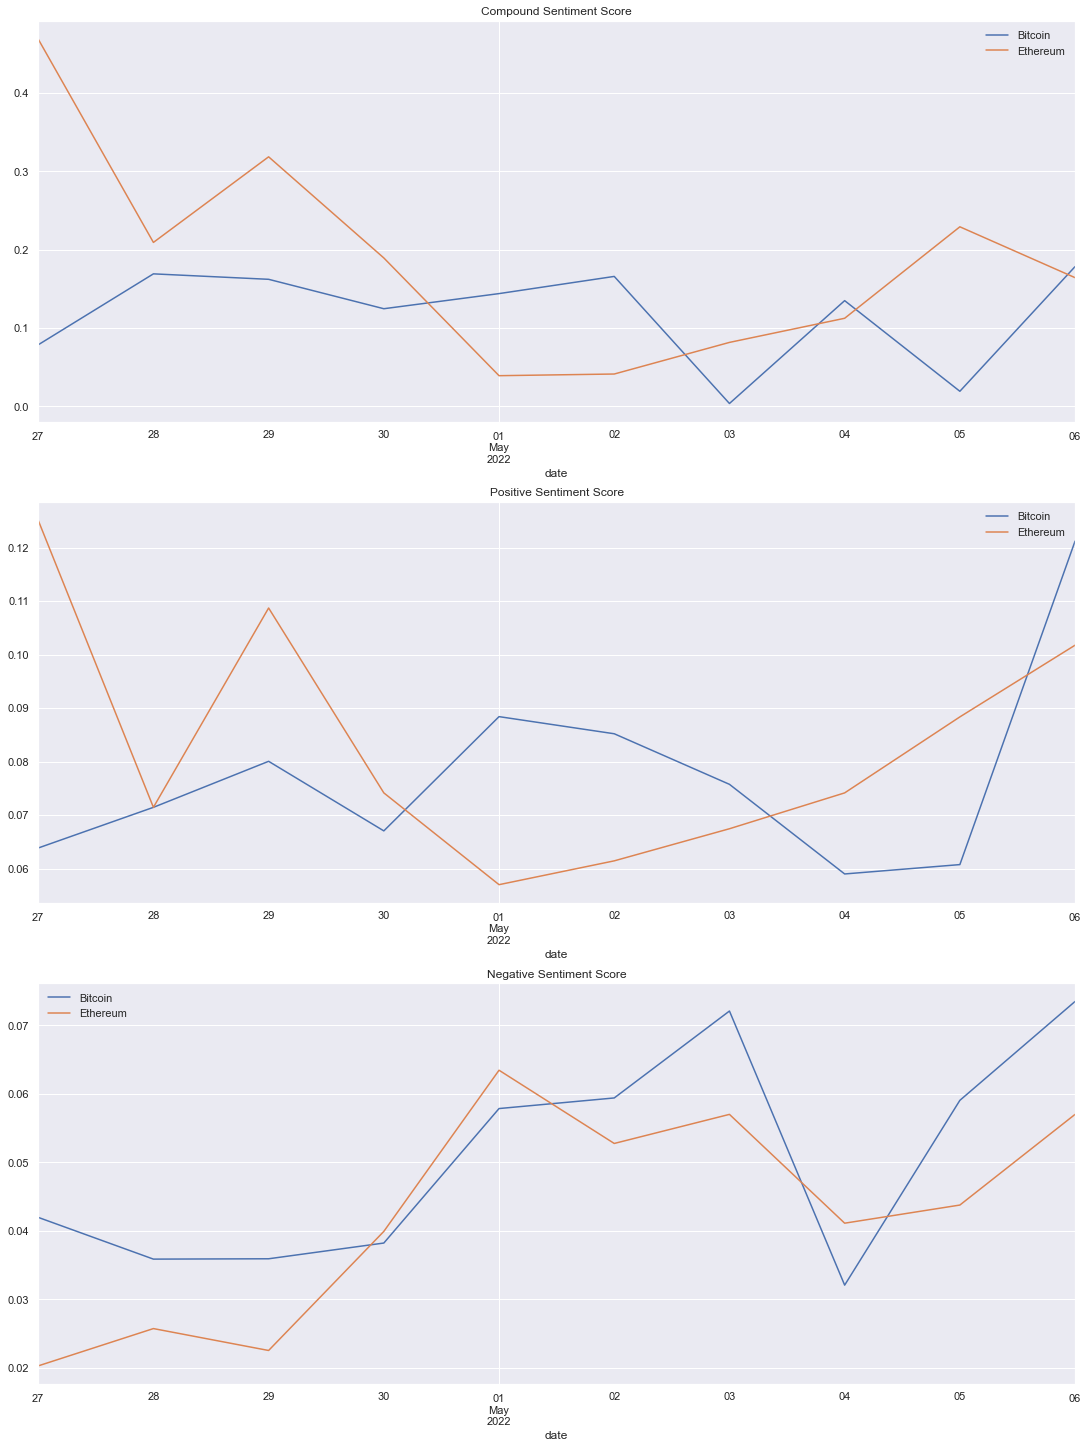

In [92]:
# Describe the Compound Sentiment
fig, axes = plt.subplots(3, 1, figsize=(15,20),constrained_layout=True)

bitcoin_sent_df.total_compound.plot(title='Compound Sentiment Score', 
                                    label='Bitcoin', 
                                    ax=axes[0])
eth_sent_df.total_compound.plot(label='Ethereum',
                               ax=axes[0])


# Describe the Positive Sentiment Score
bitcoin_sent_df.total_pos.plot(title='Positive Sentiment Score',
                               label='Bitcoin',
                              ax=axes[1])
eth_sent_df.total_pos.plot(label='Ethereum',
                          ax=axes[1])


# Describe the Negative Sentiment Score
bitcoin_sent_df.total_neg.plot(title='Negative Sentiment Score', 
                               label='Bitcoin',
                               ax=axes[2])
eth_sent_df.total_neg.plot(label='Ethereum',
                           ax=axes[2])
# fig.set(title='Sentiment Socres')
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.savefig('Images/coins_sentimental.png')

### Questions:

Q: Which coin had the highest mean positive score?

A: See plots. On different dates different coins have higher score

Q: Which coin had the highest compound score?

A: See plots. On different dates different coins have higher score

Q. Which coin had the highest positive score?

A: See plots. On different dates different coins have higher score

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [10]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re


In [11]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
# YOUR CODE HERE!


In [12]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""

    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    
    # Convert the words to lowercase
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    
    
    # Remove the stop words
    return tokens


In [13]:
# Create a new tokens column for Bitcoin

# Combine all articles in corpus into one large string
daily_tokens = []

for headline, text in zip(bitcoin_headlines, bitcoin_texts):
    daily_tokens.append(tokenizer(' '.join(headline) + ' '.join(text)))

bitcoin_sent_df['tokens'] = daily_tokens

In [24]:
# Create a new tokens column for Ethereum
daily_tokens = []

for headline, text in zip(eth_headlines, eth_texts):
    daily_tokens.append(tokenizer(' '.join(headline) + ' '.join(text)))

eth_sent_df['tokens'] = daily_tokens

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [25]:
from collections import Counter
from nltk import ngrams


In [34]:
# # Generate the Bitcoin N-grams where N=2
bitcoins_words_4_ngrams = bitcoin_sent_df['tokens'][0]
bitcoins_ngrams = ngrams(bitcoins_words_4_ngrams, n=2)
bitcoins_ngrams = [f'{x}_{y}' for x,y in bitcoins_ngrams]

In [36]:
# Generate the Ethereum N-grams where N=2
eth_words_4_ngrams = eth_sent_df['tokens'][0]
eth_ngrams = ngrams(eth_words_4_ngrams, n=2)
eth_ngrams = [f'{x}_{y}' for x,y in eth_ngrams]

In [37]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)


In [102]:
# Use token_count to get the top 10 words for Bitcoin
bitcoin_sent_df['top_10'] = [token_count(x, N=10) for x in bitcoin_sent_df['tokens']]
print(*bitcoin_sent_df['top_10'][-1], sep='\n')

('bitcoin', 24)
('char', 20)
('central', 10)
('republic', 8)
('african', 7)
('cryptocurrencies', 6)
('official', 5)
('currency', 5)
('reuters', 5)
('market', 5)


In [104]:
print(*token_count(bitcoins_ngrams, N=10), sep='\n')

('interest_rate', 4)
('us_stock', 3)
('digital_currency', 3)
('may_reuters', 3)
('rising_interest', 3)
('us_treasury', 2)
('elon_musk', 2)
('bitcoin_news', 2)
('job_report', 2)
('ugandas_central', 2)


In [96]:
# Use token_count to get the top 10 words for Ethereum
eth_sent_df['top_10'] = [token_count(x, N=10) for x in eth_sent_df['tokens']]
print(eth_sent_df['top_10'][-1], sep='\n')

In [99]:
print(*token_count(eth_ngrams, N=10), sep='\n')

('char_nvidia', 3) ('failing_disclose', 2) ('accept_cryptocurrency', 2) ('fine_cryptomining', 2) ('huobi_research', 2) ('nvidia_million', 2) ('crypto_mining', 2) ('mixing_service', 2) ('service_used', 2) ('used_north', 2)


---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = [20.0, 10.0]


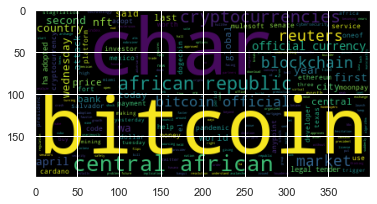

In [105]:
# Generate the Bitcoin word cloud
input_words = ' '.join(bitcoin_sent_df['tokens'][-1])
bitcoin_wc =  WordCloud().generate(input_words)
plt.imshow(bitcoin_wc)
plt.savefig('Images/bitcoin_word_cloud.png')

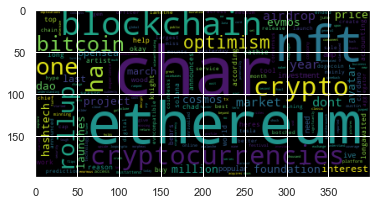

In [106]:
# Generate the Ethereum word cloud
input_words = ' '.join(eth_sent_df['tokens'][-1])
eth_wc =  WordCloud().generate(input_words)
plt.imshow(eth_wc)
plt.savefig('Images/eth_word_cloud.png')

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [56]:
import spacy
from spacy import displacy


In [60]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm


In [61]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

---
### Bitcoin NER

In [66]:
# Concatenate all of the Bitcoin text together
big_bitcoin_text = ' '.join(bitcoin_texts[0])

In [73]:
# Run the NER processor on all of the text
doc_btc = nlp(big_bitcoin_text)

In [74]:
# Render the visualization
print('Bitcoin NER')
displacy.render(doc_btc, style='ent')


Bitcoin NER


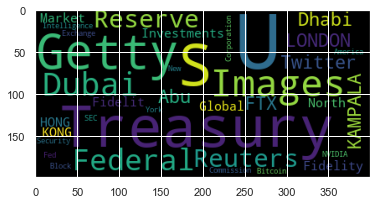

In [107]:
# List all Entities
btc_entities = [ent.text for ent in doc_btc.ents if ent.label_ in ['GPE', 'ORG']]

wc_btc_entities = WordCloud().generate(' '.join(btc_entities))
plt.imshow(wc_btc_entities)
plt.savefig('Images/btc_ner_word_cloud.png')

---

### Ethereum NER

In [75]:
# Concatenate all of the Ethereum text together
big_eth_text = ' '.join(eth_texts[0])

In [76]:
# Run the NER processor on all of the text
doc_eth = nlp(big_eth_text)

# Add a title to the document
# YOUR CODE HERE!


In [85]:
# Render the visualization
print('Ethereum NER')
displacy.render(doc_eth, style='ent')


Ethereum NER


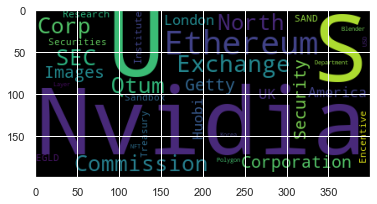

In [108]:
# List all Entities
eth_entities = [ent.text for ent in doc_eth.ents if ent.label_ in ['GPE', 'ORG']]

wc_eth_entities = WordCloud().generate(' '.join(eth_entities))
plt.imshow(wc_eth_entities)
plt.savefig('Images/eth_ner_word_cloud.png')

---